## Data-Driven Valve Condition Monitoring in Hydraulic Systems
- Name：Yiling Li
- Matrikelnummer: 108980

This notebook explores the dataset used for valve condition monitoring in hydraulic systems.
It includes data loading, preprocessing, and initial exploratory data analysis (EDA).


## import

In [10]:
import json
from pathlib import Path
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from tsfresh.feature_extraction import extract_features, EfficientFCParameters
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_predict,
    cross_val_score
)

SEED = 42
np.random.seed(SEED)


## 1.Data loading

In [14]:
# Load the dataset

from src.data_loader import load_sensor_data, load_target

sensor_data = load_sensor_data()
y= load_target()
y

0       100
1       100
2       100
3       100
4       100
       ... 
2200    100
2201    100
2202    100
2203    100
2204    100
Name: 1, Length: 2205, dtype: int64

In [15]:
print(len(sensor_data), sensor_data.keys())
print("y shape:", y.shape)
print("y unique:", y.unique())
print(sensor_data)


17 dict_keys(['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'EPS1', 'FS1', 'FS2', 'TS1', 'TS2', 'TS3', 'TS4', 'VS1', 'CE', 'CP', 'SE'])
y shape: (2205,)
y unique: [100  73  80  90]
{'PS1':         0       1       2       3       4       5       6       7       8     \
0     151.47  151.45  151.52  151.27  150.80  150.69  153.89  154.67  152.88   
1     151.11  151.12  151.16  150.92  150.70  150.62  152.40  153.21  152.81   
2     150.81  150.79  150.84  150.65  150.35  150.23  152.03  152.81  152.44   
3     150.48  150.47  150.52  150.31  150.04  149.98  151.63  152.48  152.24   
4     150.41  150.35  150.24  150.12  149.87  149.71  151.64  152.37  151.78   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2200  151.70  151.83  151.90  151.75  151.62  151.63  153.78  154.73  153.83   
2201  151.90  151.83  151.81  151.77  151.65  151.63  153.97  154.84  153.67   
2202  151.73  151.78  151.84  151.62  151.46  151.49  153.91  154.88  153.69   
2203  151.77  1

### 2.Data Understanding

#### Sensor Data

| Sensor | Physical quantity | Unit | Rate (Hz) | Associated hydraulic component |
| --- | --- | --- | --- | --- |
| PS1–PS6 | Pressure | bar | 100 | Valve / Pump |
| EPS1 | Motor power | W | 100 | Pump / Drive system |
| FS1, FS2 | Volume flow | l/min | 10 | Valve / Pump |
| TS1–TS4 | Temperature | °C | 1 | Cooling system (Kühler) |
| VS1 | Vibration | mm/s | 1 | Pump / Mechanical components |
| CE | Cooling efficiency (virtual) | % | 1 | Cooling system (Kühler) |
| CP | Cooling power (virtual) | kW | 1 | Cooling system (Kühler) |
| SE | Efficiency factor (virtual) | % | 1 | System-level / Accumulator (Akku) |


In [26]:
for name, df in sensor_data.items():
    print(f"{name} {df.shape}")

PS1 (2205, 6000)
PS2 (2205, 6000)
PS3 (2205, 6000)
PS4 (2205, 6000)
PS5 (2205, 6000)
PS6 (2205, 6000)
EPS1 (2205, 6000)
FS1 (2205, 600)
FS2 (2205, 600)
TS1 (2205, 60)
TS2 (2205, 60)
TS3 (2205, 60)
TS4 (2205, 60)
VS1 (2205, 60)
CE (2205, 60)
CP (2205, 60)
SE (2205, 60)


Aufbau der Sensor-Datensätze (jeweils seperate Dateien):
- 2205 Samples mit unterschiedlichen Zuständen -> enspricht Zeilen
- 17 Sensoren, unterschiedliche Abtastraten (1-100 Hz), aber 60 Sekunden pro Messung
    - Ein Sensor der mit 100 Hz abgetastet wird, hat 6000 Werte pro Zeile
    - Ein Sensor der mit 1 Hz abgetastet wird, hat 60 Werte pro Zeile

In [27]:
# Verteilung der Zielklassen
'''
Das Attribut *Valve Condition* unterteilt den Datensatz in vier Klassen:
- 100 -> optimaler Zustand
- 90 -> leichte Verzögerung
- 80 -> starke Verzögerung
- 73 -> kurz vor dem Ausfall

Die Klasse 100 ist mit 1125 Samples mehr als dreimal so stark vertreten wie jede andere Klassen mit jeweils 360 Samples.
'''

y.value_counts()

1
100    1125
73      360
80      360
90      360
Name: count, dtype: int64

In [28]:
y.shape

(2205,)

### 3.Data Exploration

#### 3.1 ungültige Werte
Der Datensatz hat keine ungültigen Werte：

In [29]:
# Check for missing values in sensor data
for name, df in sensor_data.items():
    print(f"{name}: {np.isnan(df.values).any()}")

PS1: False
PS2: False
PS3: False
PS4: False
PS5: False
PS6: False
EPS1: False
FS1: False
FS2: False
TS1: False
TS2: False
TS3: False
TS4: False
VS1: False
CE: False
CP: False
SE: False


#### 3.2 Wertebreich
- Die Werte der verschiedenen Sensoren unterscheiden sich deutlich und besitzen unterschiedliche physikalische Einheiten.
- Daher ist eine Z-Normalisierung grundsätzlich sinnvoll, für das Decision-Tree-Modell jedoch nicht zwingend erforderlich.

In [30]:
feature_matrix = pd.DataFrame({
    sensor_id: df_sensor.mean(axis=1)
    for sensor_id, df_sensor in sensor_data.items()
})

feature_matrix.describe()

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1,FS1,FS2,TS1,TS2,TS3,TS4,VS1,CE,CP,SE
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,160.485315,109.379906,1.753227,2.600266,9.163320,9.079363,2495.509203,6.198549,9.649453,45.424567,50.365979,47.662121,40.735654,0.613315,31.299077,1.808399,55.287900
std,4.699425,4.986585,0.251902,4.279355,0.576296,0.549589,73.836682,1.032883,0.449246,7.991933,7.396254,7.451888,8.107878,0.060260,11.575330,0.278263,8.960189
min,155.391547,104.406307,0.840252,0.000000,8.365800,8.321527,2361.747267,2.018572,8.857513,35.313783,40.859400,38.245733,30.390800,0.524367,17.555983,1.062150,18.276617
25%,158.100195,106.962382,1.729733,0.000000,8.547239,8.487167,2442.933467,6.391670,9.203397,36.237150,41.864183,39.123183,31.272567,0.555100,20.084650,1.550100,56.270183
50%,158.960895,107.730169,1.779631,0.000000,9.115781,9.031516,2480.926633,6.576673,9.692270,44.836650,49.780583,47.070250,40.429050,0.610183,27.392533,1.739683,58.758150
75%,161.000735,109.421612,1.932047,3.503266,9.844351,9.729275,2548.211467,6.657508,10.155008,54.104317,58.584467,55.694433,49.409500,0.649850,46.677383,2.148483,59.656900
max,180.922708,131.589089,2.023398,10.207068,9.978510,9.856591,2740.641000,6.722707,10.403098,57.899283,61.958467,59.423167,53.060417,0.839067,47.903667,2.840100,60.755300


In [12]:
# prüfen auf Außreißer
# Source: https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list
def outlier_mask_iqr(x: np.ndarray, iq_range: float = 0.8):
    """
    x : np.ndarray
        Eindimensionales Array mit Messwerten.
    iq_range : float
        Anteil der mittleren Daten, der beibehalten wird.
        Beispiel: 0.8 bedeutet, dass die mittleren 80 % der Werte
        als normal betrachtet werden.
    Rückgabe
    --------
    mask : np.ndarray (bool)
        True = normaler Wert, False = Ausreißer
    stats : dict
        Statistische Kennzahlen zur Ausreißeranalyse
    """
    # Entferne ungültige Werte (NaN / Inf)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return None, {}

    # Berechnung der Quantile
    pcnt = (1 - iq_range) / 2
    q_low, q_med, q_high = np.quantile(x, [pcnt, 0.5, 1 - pcnt])
    iqr = q_high - q_low

    # Definition der unteren und oberen Grenze um den Median
    low_bound = q_med - iqr
    high_bound = q_med + iqr

    mask = (x >= low_bound) & (x <= high_bound)
    # Zusammenfassung statistischer Informationen
    stats = {
        "q_low": q_low,
        "q_med": q_med,
        "q_high": q_high,
        "iqr": iqr,
        "low_bound": low_bound,
        "high_bound": high_bound,
        "Anzahl_Messwerte": int(x.size),
        "Anzahl_Ausreißer": int((~mask).sum()),
        "Ausreißeranteil": float((~mask).sum() / x.size)
    }
    return mask, stats


def outlier_report_per_sensor(sensor_data: dict, iq_range: float = 0.8) -> pd.DataFrame:
    """
    Erstellt einen Ausreißerbericht für jeden Sensor.

    Parameter
    ----------
    sensor_data : dict[str, pd.DataFrame]
        Dictionary mit Sensordaten.Jeder DataFrame hat die Form (2205 Messungen, Zeitpunkte).
    iq_range : float
        Anteil der als normal betrachteten Werte (Standard: 0.8).

    Rückgabe
    --------
    pd.DataFrame
        Tabelle mit Ausreißerstatistiken pro Sensor
    """
    rows = []
    for sensor_name, df in sensor_data.items():
        x = df.to_numpy(dtype=float).flatten()
        _, stats = outlier_mask_iqr(x, iq_range=iq_range)
        rows.append({"sensor": sensor_name, **stats})

    return pd.DataFrame(rows).sort_values("Ausreißeranteil", ascending=False)


# Anzeige der wichtigsten Kennzahlen
report = outlier_report_per_sensor(sensor_data, iq_range=0.8)
display(report[["sensor", "Anzahl_Messwerte", "Anzahl_Ausreißer", "Ausreißeranteil"]])


,sensor,Anzahl_Messwerte,Anzahl_Ausreißer,Ausreißeranteil
3,PS4,13230000,1321917,0.099918
13,VS1,132300,3829,0.028942
2,PS3,13230000,80145,0.006058
15,CP,132300,730,0.005518
7,FS1,1323000,5795,0.004380
0,PS1,13230000,0,0.000000
10,TS2,132300,0,0.000000
14,CE,132300,0,0.000000
12,TS4,132300,0,0.000000
11,TS3,132300,0,0.000000


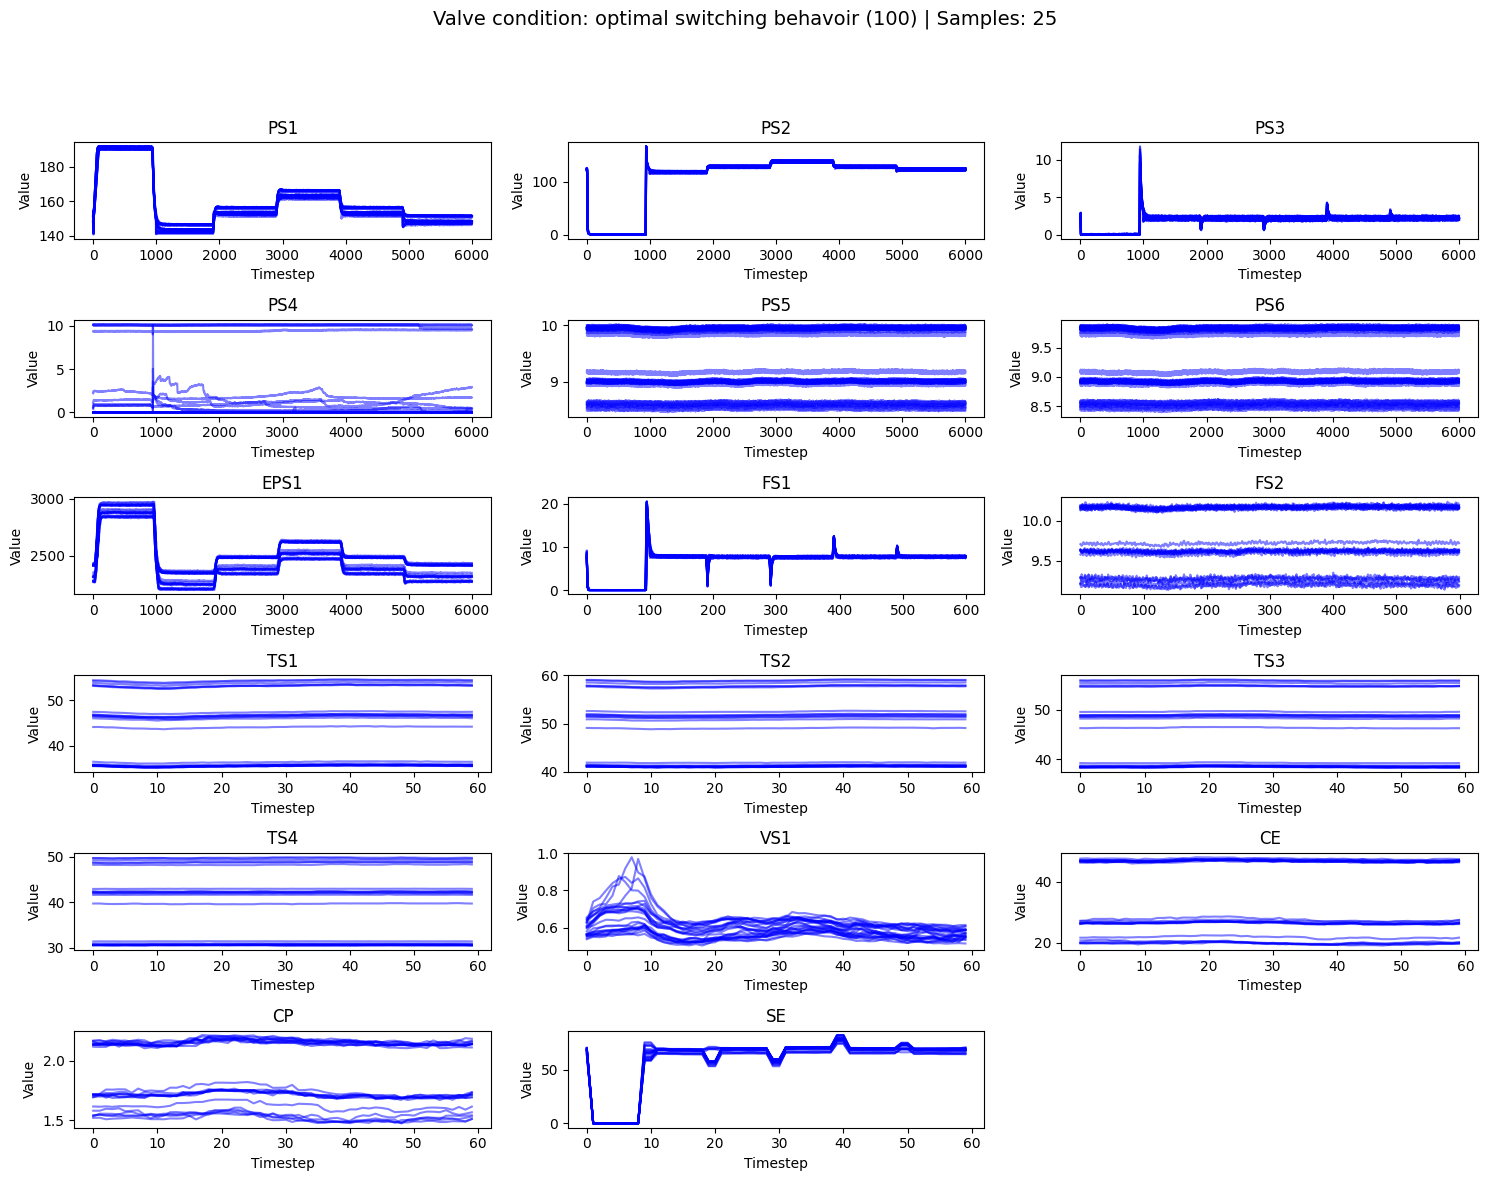

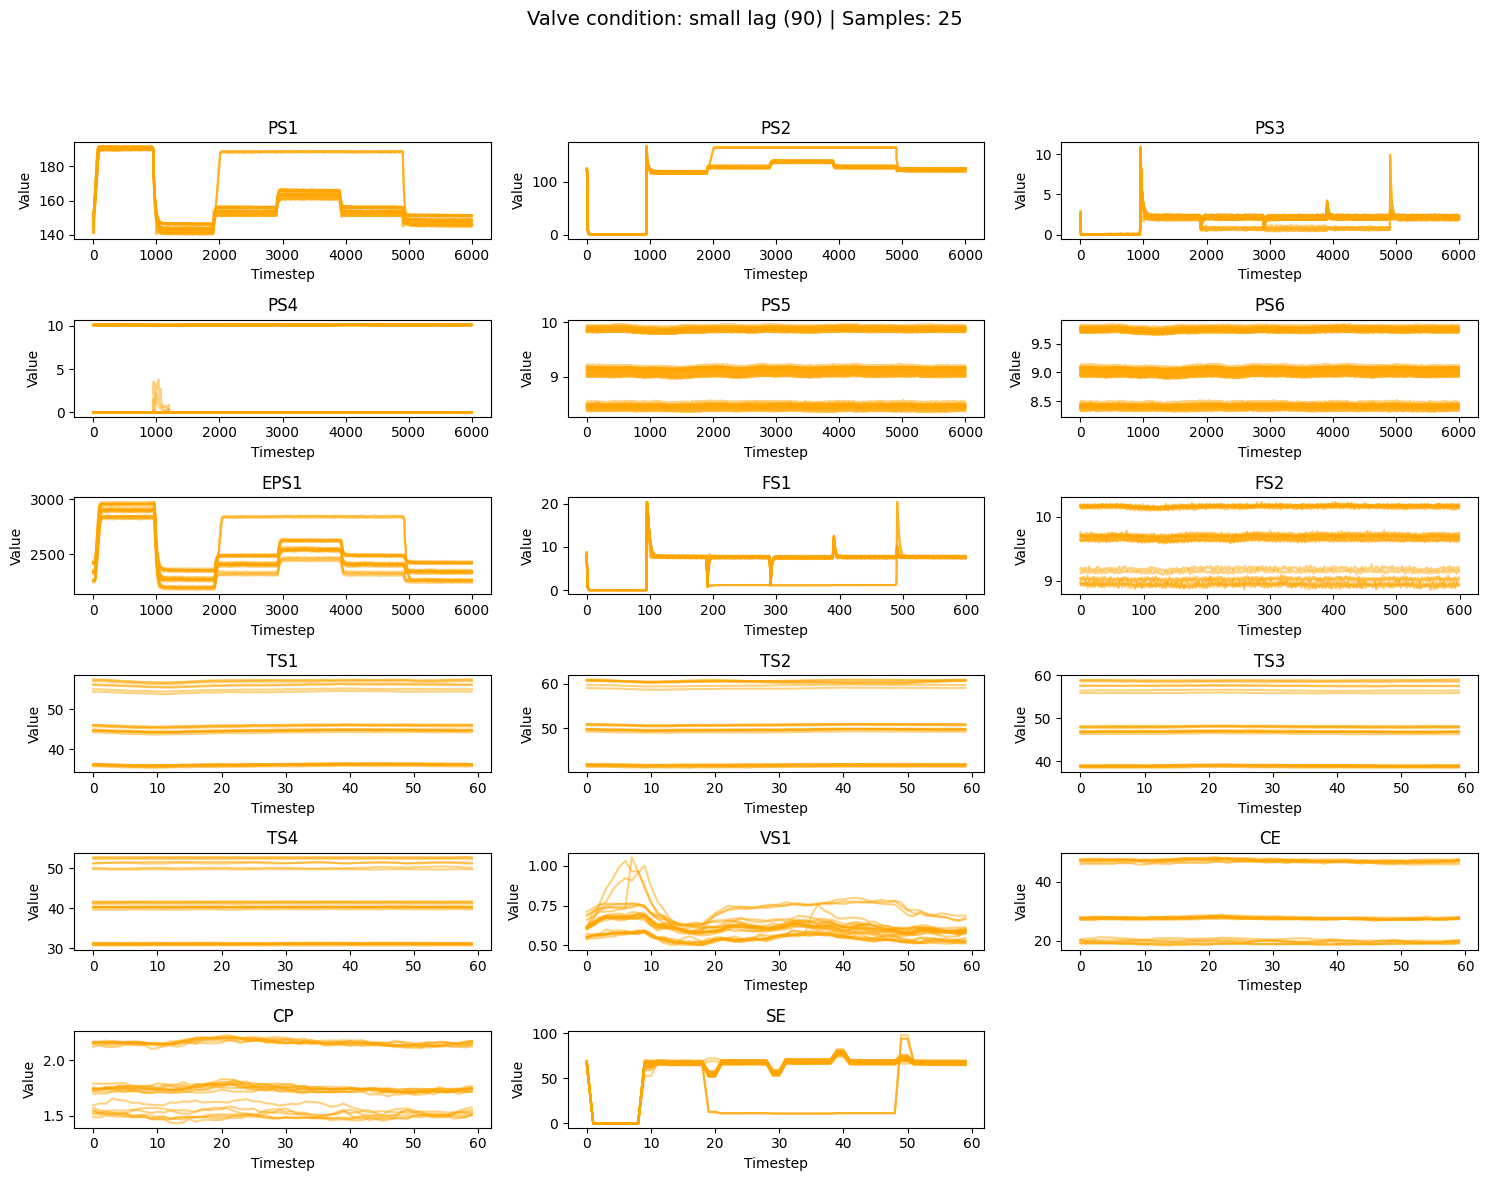

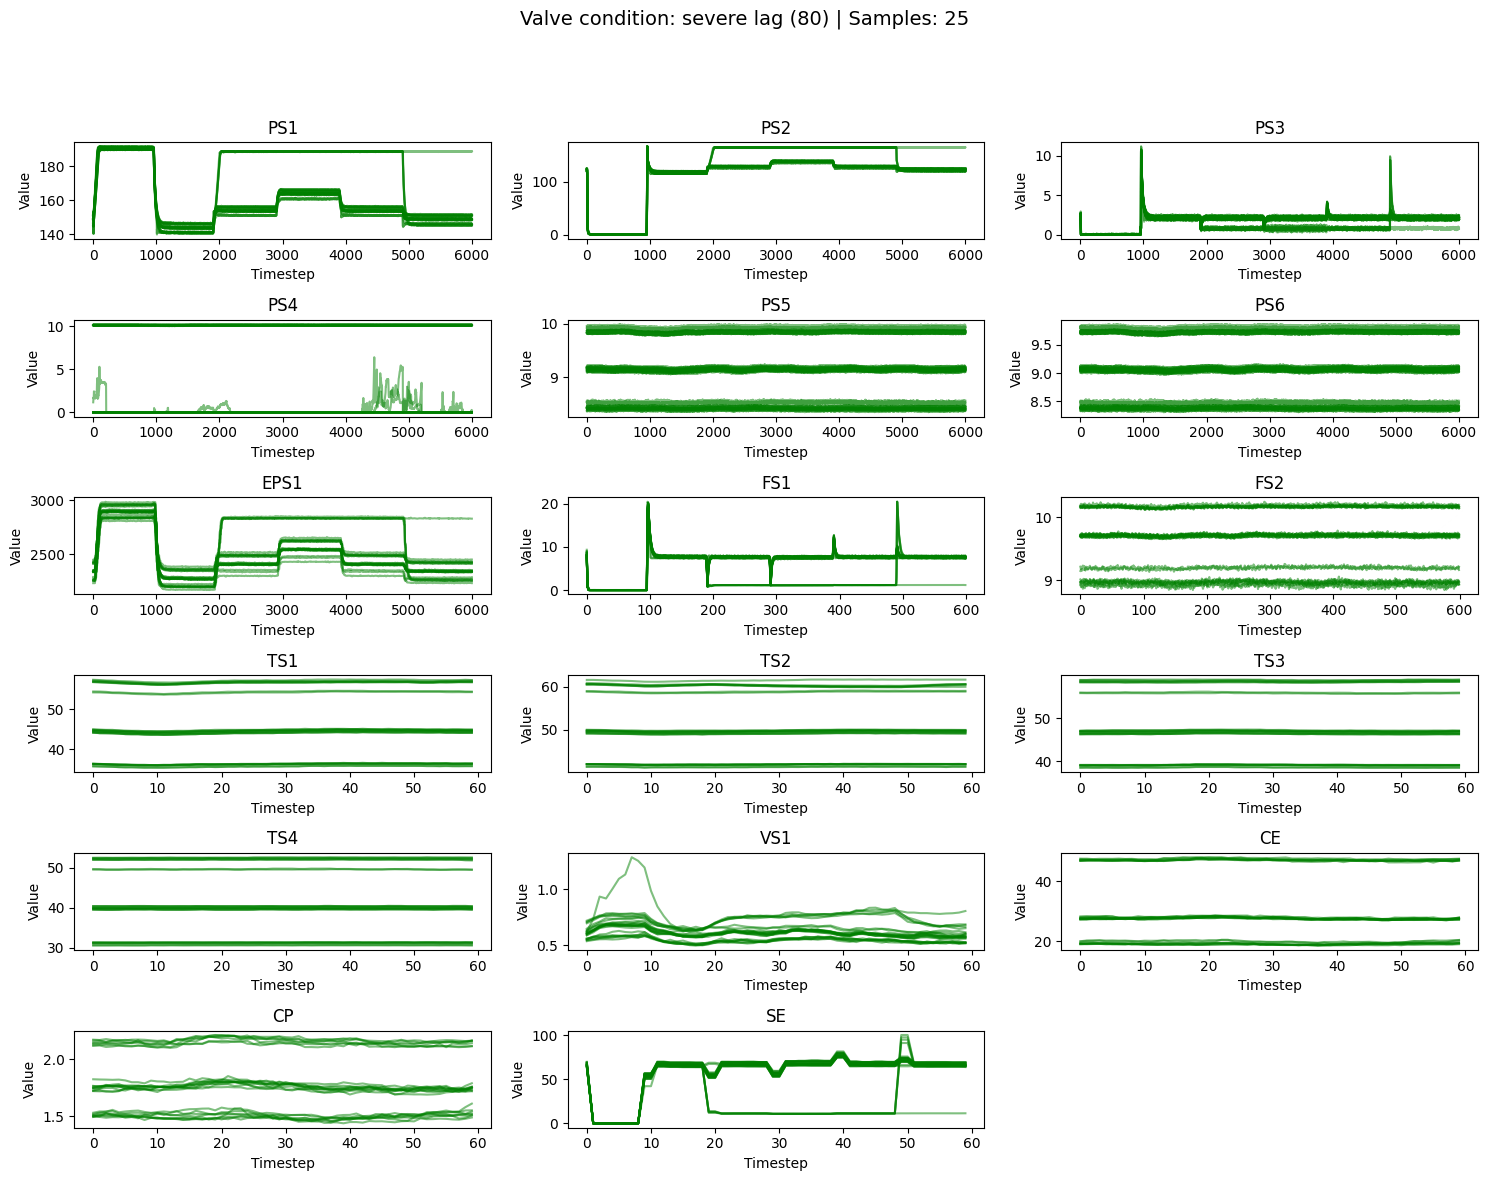

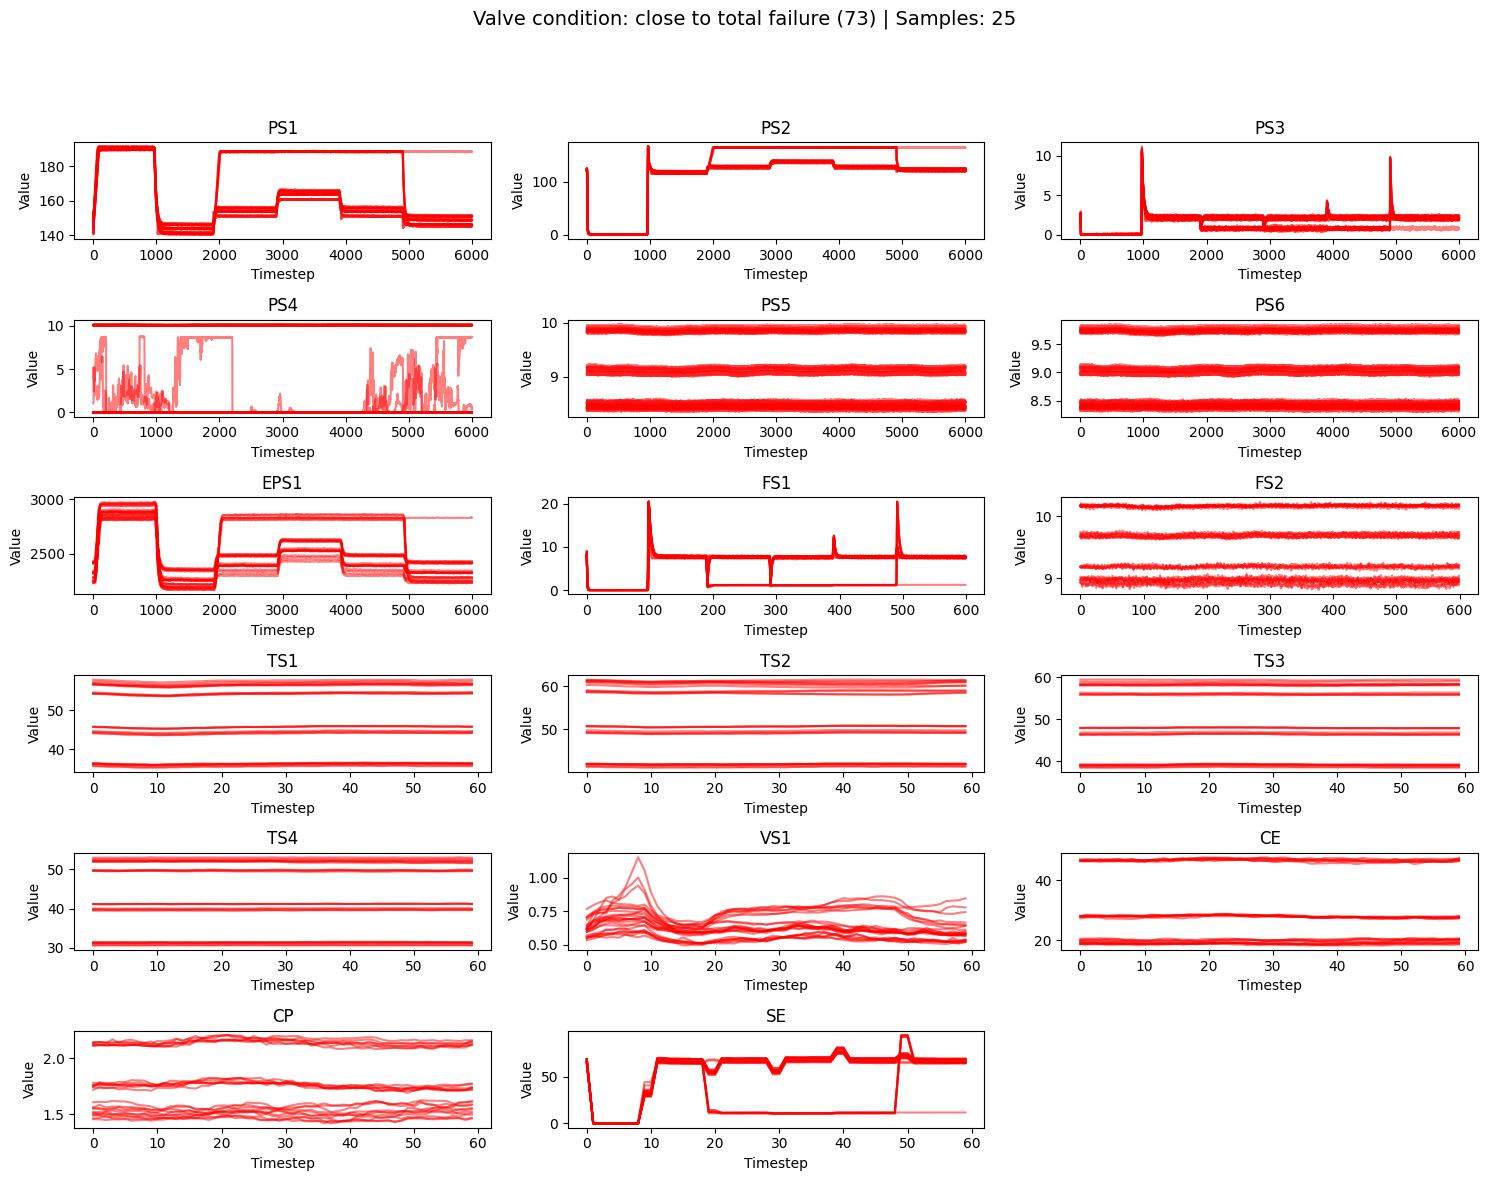

In [31]:
N_SAMPLES = 25
N_COLS = 3
RNG = np.random.default_rng(seed=SEED)

def safe_random_choice(idx, n, rng):
    if len(idx) == 0:
        return np.array([], dtype=int)
    return rng.choice(idx, min(n, len(idx)), replace=False)


# Klassen-Definitionen
classes = {
    "optimal": {"value": 100, "color": "blue", "label": "optimal switching behavoir"},
    "small": {"value": 90,"color": "orange", "label": "small lag"},
    "severe": {"value": 80, "color": "green", "label": "severe lag"},
    "failure": {"value": 73, "color": "red", "label": "close to total failure"}
}

# Indizes + Samples erzeugen
for cls in classes.values():
    idx = np.where(df_target.values == cls["value"])[0]
    cls["samples"] = safe_random_choice(idx, N_SAMPLES, RNG)


# Plot pro Klasse
n_sensors = len(sensor_data)
n_rows = math.ceil(n_sensors / N_COLS)

for cls_key, cls in classes.items():
    n_samples_cls = len(cls["samples"])

    plt.figure(figsize=(5 * N_COLS, 2 * n_rows))
    plt.suptitle(
        f"Valve condition: {cls['label']} ({cls['value']}) | Samples: {n_samples_cls}",
        fontsize=14
    )

    for i, key in enumerate(sensor_data.keys()):
        plt.subplot(n_rows, N_COLS, i + 1)
        plt.title(key)

        for v in cls["samples"]:
            plt.plot(
                sensor_data[key].iloc[v],
                color=cls["color"],
                alpha=0.5
            )

        # Achsenbeschriftung
        plt.xlabel("Timestep")
        plt.ylabel("Value")

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

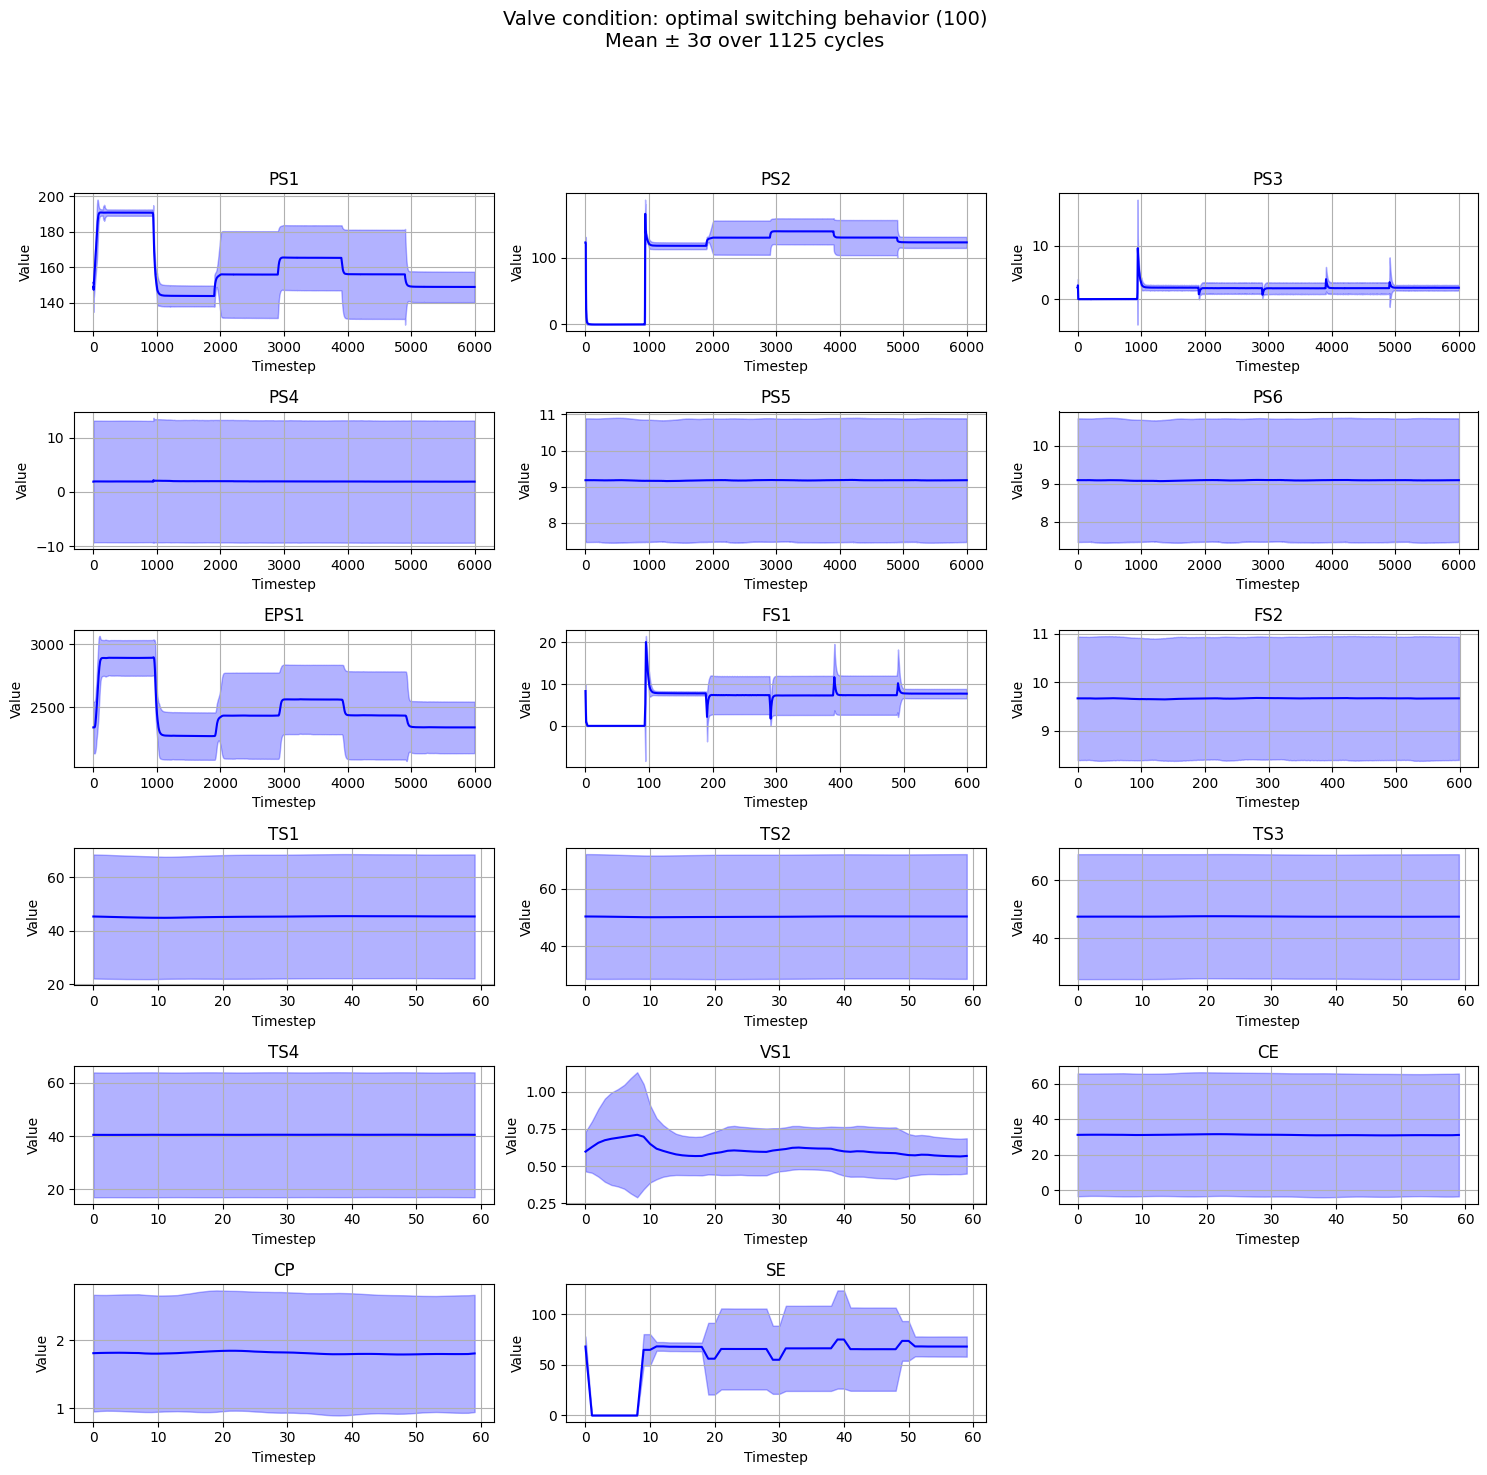

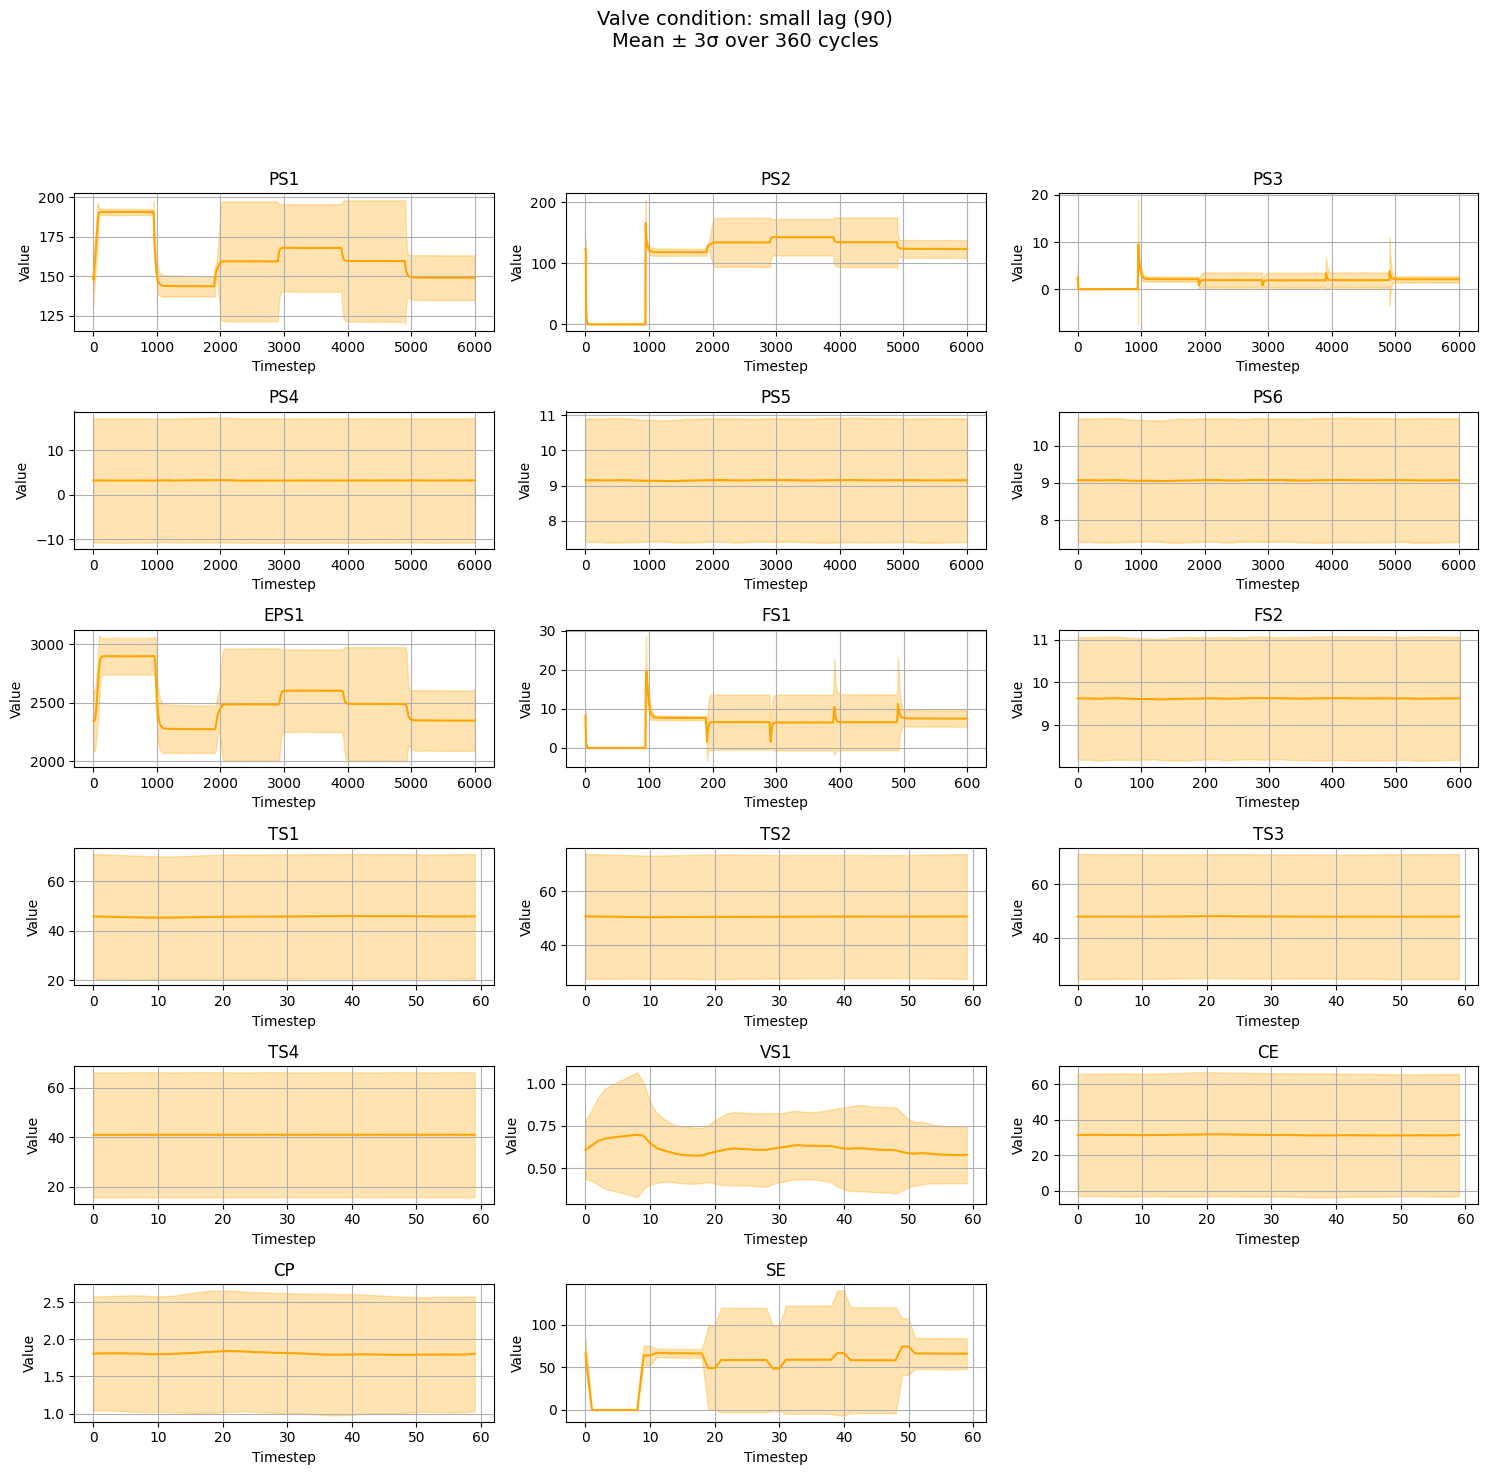

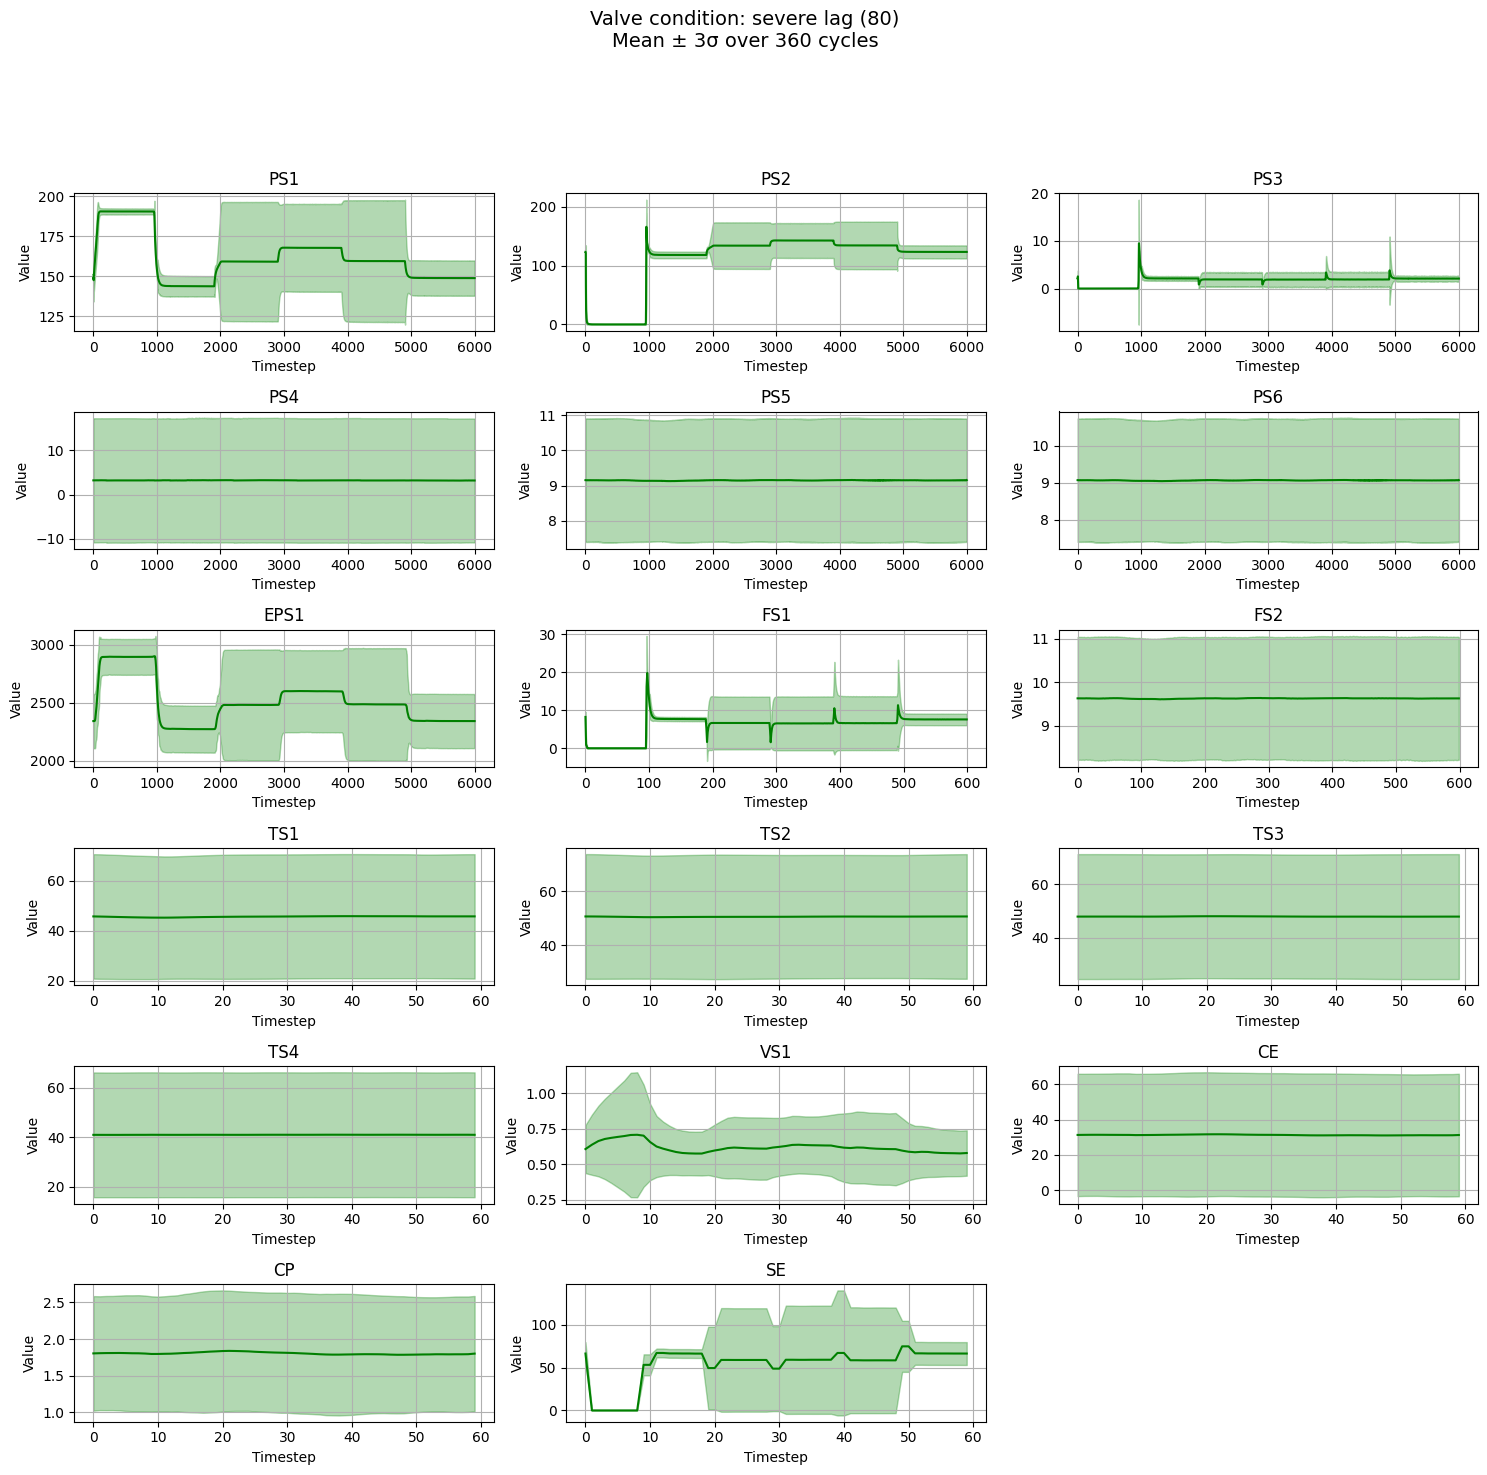

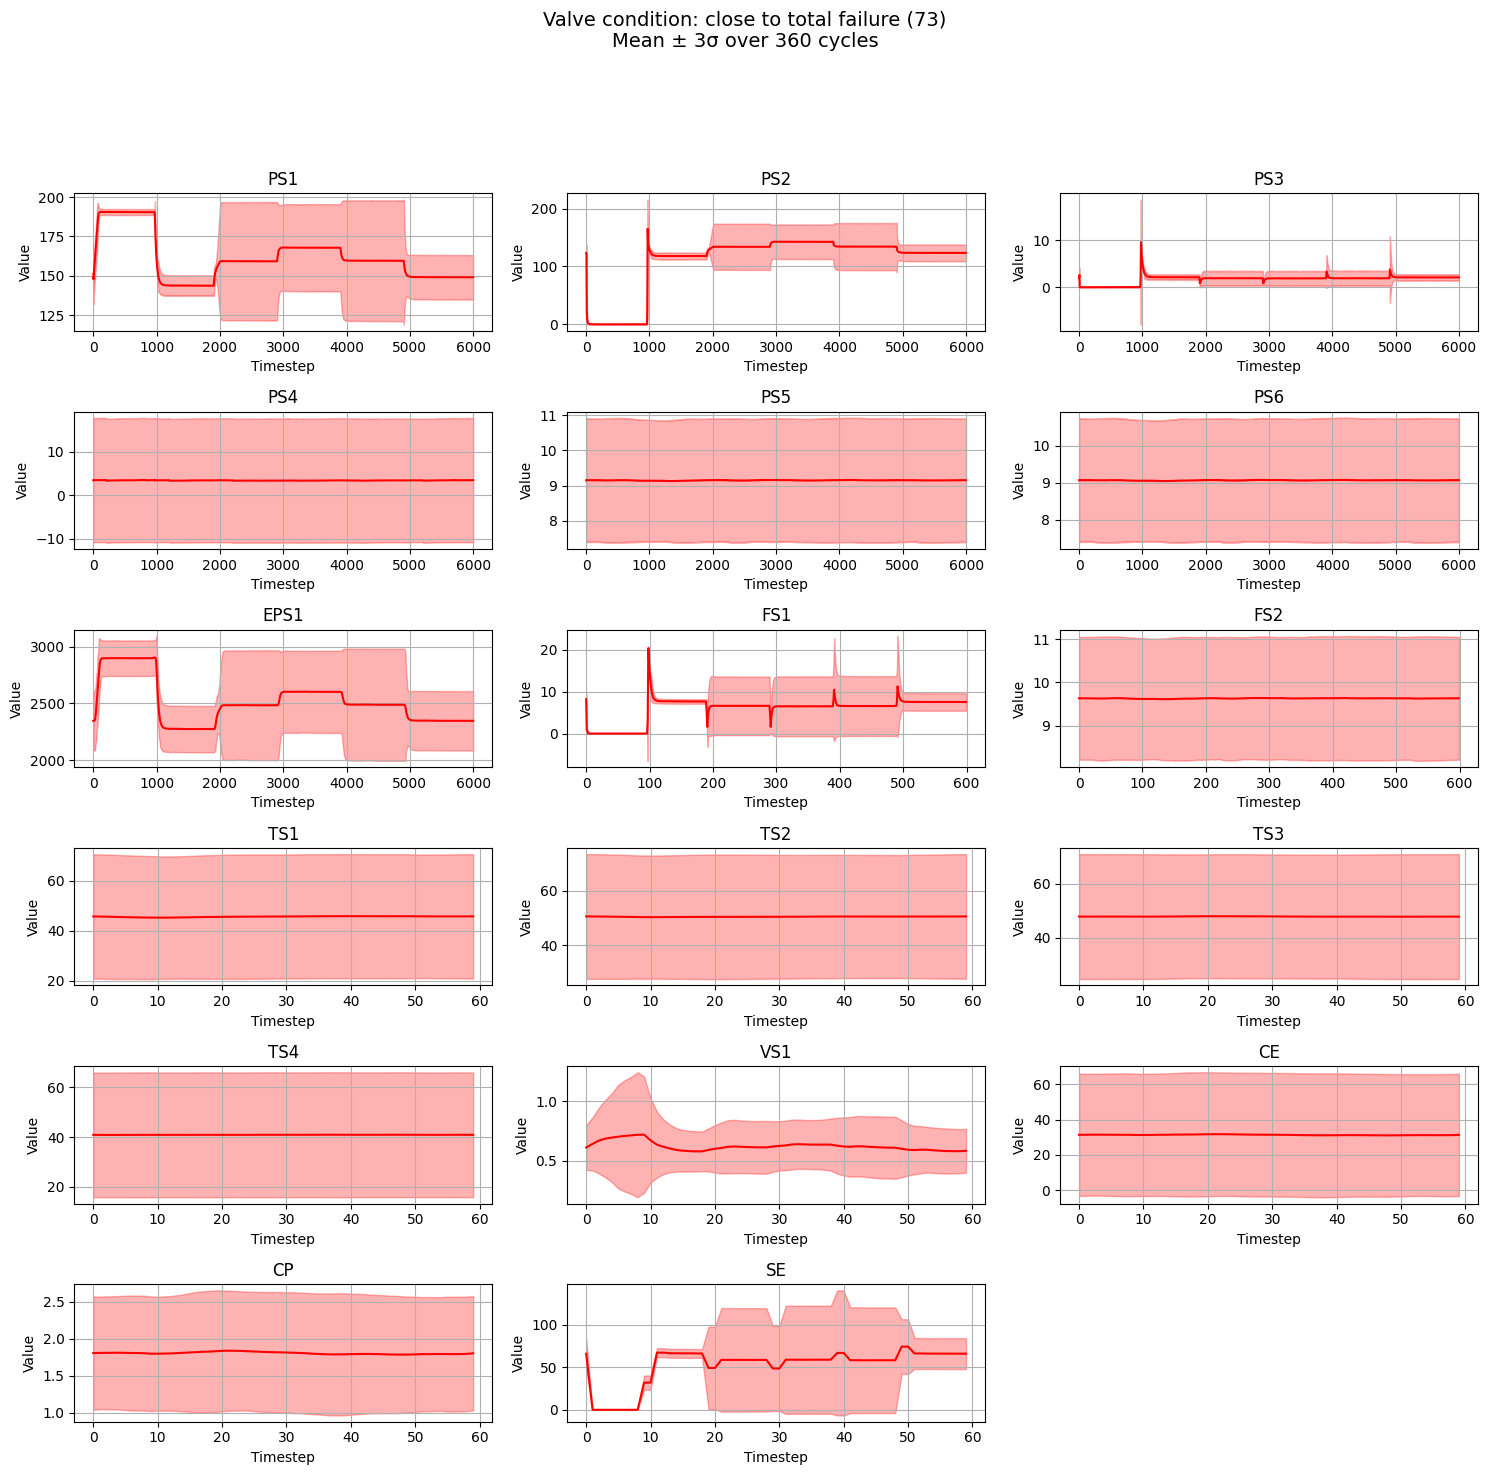

In [32]:
N_COLS = 3

# Klassen
classes = {
    "optimal": {"value": 100, "color": "blue",   "label": "optimal switching behavior"},
    "small":   {"value": 90,  "color": "orange", "label": "small lag"},
    "severe":  {"value": 80,  "color": "green",  "label": "severe lag"},
    "failure": {"value": 73,  "color": "red",    "label": "close to total failure"},
}

# Alle Zyklen pro Klasse bestimmen
for cls in classes.values():
    cls["samples"] = np.where(df_target.values == cls["value"])[0]


# Layout
n_sensors = len(sensor_data)
n_rows = math.ceil(n_sensors / N_COLS)

# === Plot pro Klasse ===
for cls in classes.values():

    samples = cls["samples"]
    if len(samples) == 0:
        continue

    plt.figure(figsize=(5 * N_COLS, 2.5 * n_rows))
    plt.suptitle(
        f"Valve condition: {cls['label']} ({cls['value']})\n"
        f"Mean ± 3σ over {len(samples)} cycles",
        fontsize=14
    )

    for i, sensor in enumerate(sensor_data.keys()):
        ax = plt.subplot(n_rows, N_COLS, i + 1)
        ax.set_title(sensor)

        # Daten: (n_cycles, timesteps)
        data = sensor_data[sensor].iloc[samples].values

        mean = data.mean(axis=0)
        std = data.std(axis=0)

        ax.plot(mean, color=cls["color"], label="Mean")
        ax.fill_between(
            range(len(mean)),
            mean - 3 * std,
            mean + 3 * std,
            color=cls["color"],
            alpha=0.3,
            label="±3σ"
        )

        ax.set_xlabel("Timestep")
        ax.set_ylabel("Value")
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

In [33]:
feature_matrix.var()

PS1       22.084591
PS2       24.866035
PS3        0.063454
PS4       18.312876
PS5        0.332117
PS6        0.302048
EPS1    5451.855603
FS1        1.066847
FS2        0.201822
TS1       63.871000
TS2       54.704580
TS3       55.530634
TS4       65.737688
VS1        0.003631
CE       133.988270
CP         0.077430
SE        80.284993
dtype: float64

### Optimierung: Korrelationsanalyse (Mittelwerte der Samples)

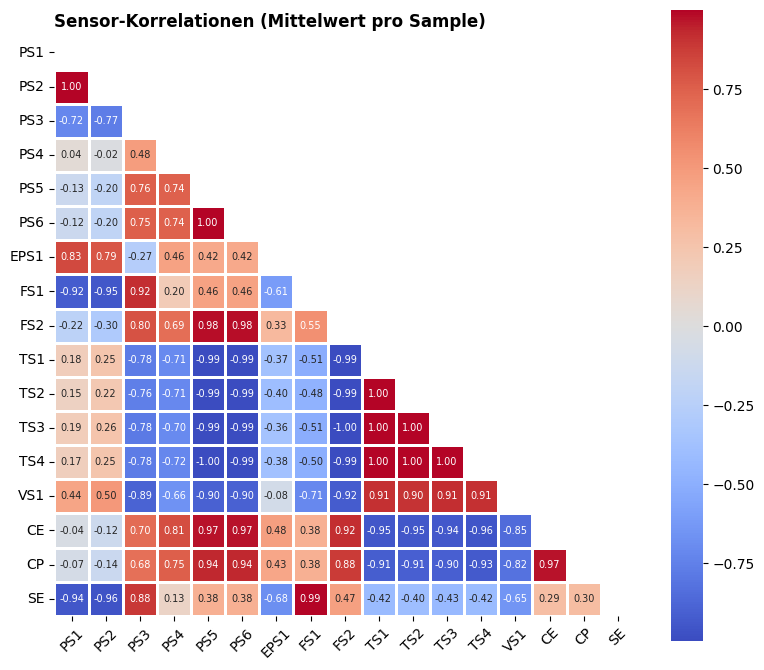

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))

corr = feature_matrix.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask=mask,
    ax=ax,
    center=0,
    square=True,
    cmap="coolwarm",
    linewidths=0.8,
    cbar_kws={"shrink": 0.82},
    annot=True,
    fmt=".2f",
    annot_kws={"size": 7}
)

ax.set_title(
    "Sensor-Korrelationen (Mittelwert pro Sample)",
    loc="left",
    fontweight="bold"
)

ax.tick_params(axis="x", rotation=45)
ax.tick_params(axis="y", rotation=0)

plt.tight_layout()
plt.show()

### Ergebnis der Deskriptiven Statistik und Korrelationsanalyse (Mittelwerte der Zyklen)

Eine Modellierung mit allen 17 Sensoren sollte demnach keinen nennenswerten Performancegewinn liefern (unter Vorbehalt, da während der Modellierung noch weitere Sensoren ausgeschlossen werden können).

Folgende Sensoren lassen sich zunächst vernachlässigen:

- PS3 -> Varianz: 0.063454
- PS5 -> Varianz: 0.332117
- PS6 -> Varianz = 0.302048, Korrelation mit PS5 (r=1)
- FS2 -> Varianz = 0.201822, Korrelation mit PS5 (r=0.98)
- TS2 -> Korrelation mit TS1, TS3, TS4 (jeweils r=1)
- TS3 -> Korrelation mit TS1, TS2, TS4 (jeweils r=1)
- TS4 -> Korrelation mit TS1, TS2, TS3 (jeweils r=1)
- VS1 -> Varianz: 0.003631
- CP  -> Varianz: 0.077430

Demnach reduziert sich die Anzahl (zunächst) auf die folgenden 8 Modelle:
- PS1 -> Varianz: 22.084591
- PS2 -> Varianz: 24.866035
- PS4 -> Varianz: 18.312876
- EPS1 -> Varianz: 5451.855603
- FS1 -> Varianz: 1.066847
- TS1 -> Varianz: 63.871000
- CE -> Varianz: 133.988270
- SE -> Varianz: 80.284993